In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import utilities3
import importlib
importlib.reload(utilities3)

torch.manual_seed(0)
np.random.seed(0)

In [2]:
#Complex multiplication
def compl_mul3d(a, b):
    # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
    op = partial(torch.einsum, "bixyz,ioxyz->boxyz")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

################################################################
# 3d fourier layers
################################################################

class SpectralConv3d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d_fast, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 3, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.irfft(out_ft, 3, normalized=True, onesided=True, signal_sizes=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class SimpleBlock3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(SimpleBlock3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)


        self.conv0 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv4 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv5 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv6 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv7 = SpectralConv3d_fast(self.width, self.width, self.modes1, self.modes2, self.modes3)
        
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.w4 = nn.Conv1d(self.width, self.width, 1)
        self.w5 = nn.Conv1d(self.width, self.width, 1)
        self.w6 = nn.Conv1d(self.width, self.width, 1)
        self.w7 = nn.Conv1d(self.width, self.width, 1)
        
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)
        self.bn4 = torch.nn.BatchNorm3d(self.width)
        self.bn5 = torch.nn.BatchNorm3d(self.width)
        self.bn6 = torch.nn.BatchNorm3d(self.width)
        self.bn7 = torch.nn.BatchNorm3d(self.width)
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn3(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv4(x)
        x2 = self.w4(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn4(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv5(x)
        x2 = self.w5(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn5(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv6(x)
        x2 = self.w6(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn6(x1 + x2)
        x = F.relu(x)
        
        x1 = self.conv7(x)
        x2 = self.w7(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = self.bn7(x1 + x2)
               
        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net3d(nn.Module):
    def __init__(self, modes, width):
        super(Net3d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock3d(modes, modes, modes, width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

In [3]:
ntrain = 1000
ntest = 200

modes = 4
width = 8

batch_size = 10
batch_size2 = batch_size

epochs = 10
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

sub = 1
S = 64 // sub
T_in = 10
T = 10

In [4]:
reader = utilities3.MatReader('data/NavierStokes_V1e-5_N1200_T20.mat')
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = utilities3.MatReader('data/NavierStokes_V1e-5_N1200_T20.mat')
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

In [5]:
print(f'The shape of train_a is {train_a.shape} and the shape of train_u is {train_u.shape}')
print(f'The shape of test_a is {test_a.shape} and the shape of test_u is {test_u.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10]) and the shape of train_u is torch.Size([1000, 64, 64, 10])
The shape of test_a is torch.Size([200, 64, 64, 10]) and the shape of test_u is torch.Size([200, 64, 64, 10])


In [6]:
a_normalizer = utilities3.UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = utilities3.UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

In [7]:
print(f'The shape of train_a is {train_a.shape} and the shape of test_a is {test_a.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10, 10]) and the shape of test_a is torch.Size([200, 64, 64, 10, 10])


In [8]:
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])

In [9]:
train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1]),
                       gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

In [10]:
print(f'The shape of train_a is {train_a.shape} and the shape of test_a is {test_a.shape}')

The shape of train_a is torch.Size([1000, 64, 64, 10, 13]) and the shape of test_a is torch.Size([200, 64, 64, 10, 13])


In [11]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

In [12]:
device = torch.device('cuda')

In [13]:
model = Net3d(modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(model.count_params())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


myloss = utilities3.LpLoss(size_average=False)
y_normalizer.cuda()

264241


In [14]:
train_loss =[]
test_loss =[]
for ep in range(1):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
#         print(l2)
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
    train_loss.append(train_l2/ntrain)

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
        test_loss.append(test_l2/ntest)

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:590.)
C:\Users\Saad.LAKES\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:602.)


0 12.516563900000165 0.4346744956076145 0.40211517190933227 0.32893134117126466


In [ ]:
plt.plot(train_loss,'b',label='Training Loss')
plt.plot(test_loss,'r',label='Testing Loss')
plt.legend()
plt.show()

In [15]:
pred = torch.zeros(test_u.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(out)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         print(index, test_l2)
        index = index + 1

In [16]:
print(f'The shape of the predictions is {pred.shape} and the shape of actual is {test_u.shape}')

The shape of the predictions is torch.Size([200, 64, 64, 10]) and the shape of actual is torch.Size([200, 64, 64, 10])


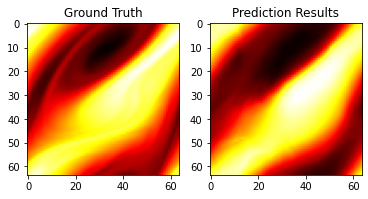

In [17]:
plt.subplot(121)
plt.imshow(test_u[1,:,:,2],cmap='hot')
plt.title('Ground Truth')

plt.subplot(122)
plt.imshow(pred[1,:,:,2],cmap='hot')
plt.title('Prediction Results')
plt.show()

In [18]:
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)

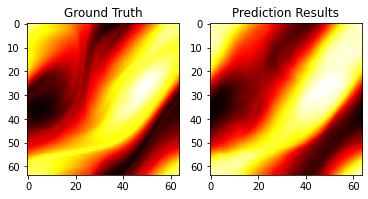

In [19]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax1= fig.add_subplot(122)
ax.title.set_text('Ground Truth')
ax1.title.set_text('Prediction Results')
# ax1.title('Prediction Results')
def plot(i):
    data = test_u[0,:,:,i]
    pred_data = pred[0,:,:,i]
    heatmap = ax.imshow(data,cmap='hot')
    heatmap1= ax1.imshow(pred_data,cmap='hot')
ani = animation.FuncAnimation(fig,plot,interval=10000000,frames=9)
ani.save('NS Results_20layers8nodes.mp4',writer=writer)